In [1]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/arko/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
import string
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
reddit_data_extracted = pd.read_csv('../data_raw/reddit_soccer_dataset.csv')

In [4]:
reddit_data_extracted

,team,title,selftext,comment,replies
0,Arsenal,Sporting CP [1] - 3 Arsenal - Goncalo Inacio 4...,NaN,Can’t fucking stand how complacent this team g...,NaN
1,Arsenal,Sporting CP [1] - 3 Arsenal - Goncalo Inacio 4...,NaN,Oh no lmao,NaN
2,Arsenal,Sporting CP [1] - 3 Arsenal - Goncalo Inacio 4...,NaN,Don't worry lads I've got this\n\nhttps://prev...,NaN
3,Arsenal,Sporting CP [1] - 3 Arsenal - Goncalo Inacio 4...,NaN,Hold off on the subs for now lol,NaN
4,Arsenal,Taught my Dog Mango a new trick!,NaN,Put him on corners,He'll give Martinelli a run for his money 💰 ht...
...,...,...,...,...,...
51955,Man City,[Daily Discussion] Tuesday 19 Nov 2024,This thread is for **all** general discussion!...,I think I want City to sign a player that's a ...,NaN
51956,Man City,[Daily Discussion] Tuesday 19 Nov 2024,This thread is for **all** general discussion!...,Another thought is that Viana might be someone...,NaN
51957,Man City,[Daily Discussion] Tuesday 19 Nov 2024,This thread is for **all** general discussion!...,"The docs sound good to me, all whilst knowing ...",Yeah I'll take the docs
51958,Man City,[Daily Discussion] Tuesday 19 Nov 2024,This thread is for **all** general discussion!...,Yeah the fiction part is what got me. \n\nHopi...,NaN


In [5]:
vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(clean_comment):
    if isinstance(clean_comment, str):
        sentiment = vader_analyzer.polarity_scores(clean_comment)
        return sentiment['compound']
    return None  

In [6]:
reddit_data_extracted['clean_comment'] = reddit_data_extracted['comment'].fillna('')  # Replace NaN with an empty string
reddit_data_extracted['clean_replies'] = reddit_data_extracted['replies'].fillna('')  # Replace NaN with an empty string

In [7]:
reddit_data_extracted['combined'] = reddit_data_extracted['clean_comment'].fillna('') + ' ' + reddit_data_extracted['clean_replies'].fillna('')

In [8]:
reddit_data_extracted['overall_sentiment'] = reddit_data_extracted['combined'].apply(vader_sentiment)

In [9]:
#categorisation:
reddit_data_extracted['category'] = np.where(reddit_data_extracted['overall_sentiment'] >= 0.00, 1, 0)

In [10]:
combined, sentiment = list(reddit_data_extracted['combined']), list(reddit_data_extracted['category'])

In [11]:
data = reddit_data_extracted[["combined", "category"]]

In [12]:
# Set limit according to size of least frequent category
limit = 13000
data_pos = data[data['category'] == 1][:limit]
#data_neut = data[data['category'] == 0]
data_neg = data[data['category'] == 0][:limit]

dataset = pd.concat([data_pos, data_neg])

In [13]:
dataset.to_csv("../data_processed/large_reddit_labelled.csv")

In [14]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(stopwordlist)
punctuations_list = string.punctuation

In [15]:
#Converting all clean_comment to lowercase for uniformity
dataset['combined']=dataset['combined'].str.lower()


In [16]:
'''

Now we create a few function to help us with cleaning of data
1. Removing stopwords from the clean_comment
2. Defining and applying a function to remove punctuation
3. Removing any urls from the clean_comment
4. Removing any numbers present in our clean_comment

'''
def cleaning_stopwords(clean_comment):
    return " ".join([word for word in str(clean_comment).split() if word not in STOPWORDS])

def cleaning_punctuations(clean_comment):
    translator = str.maketrans('', '', punctuations_list)
    return clean_comment.translate(translator)

# def cleaning_repeating_char(clean_comment):
#     return re.sub(r'(.)1+', r'1', clean_comment)

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [17]:
dataset['combined'] = dataset['combined'].apply(lambda combined: cleaning_stopwords(combined))
dataset['combined']= dataset['combined'].apply(lambda x: cleaning_punctuations(x))
dataset['combined'] = dataset['combined'].apply(lambda x: cleaning_URLs(x))
dataset['combined'] = dataset['combined'].apply(lambda x: cleaning_numbers(x))

In [18]:
# reset index for consistency 
dataset = dataset.reset_index(drop=True)

In [19]:
lm = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# created a function for lemmatizing the clean_column
def lemmatizer_on_clean_column(data):
    clean_column = [lm.lemmatize(word) for word in data]
    return clean_column

In [20]:
dataset['combined'] = dataset['combined'].apply(tokenizer.tokenize)
dataset['combined'] = dataset['combined'].apply(lambda x: lemmatizer_on_clean_column(x))

In [21]:
#comment:
X = dataset.combined
y = dataset.category

# Converting tokenized clean_comment back to strings
X = X.apply(lambda x: ' '.join(x))

# Separating the 80% data for training data and 20% for testing data with a set random state to ensure same results
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =26105111)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  267474


In [22]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      2614
           1       0.71      0.93      0.81      2586

    accuracy                           0.78      5200
   macro avg       0.81      0.78      0.77      5200
weighted avg       0.81      0.78      0.77      5200



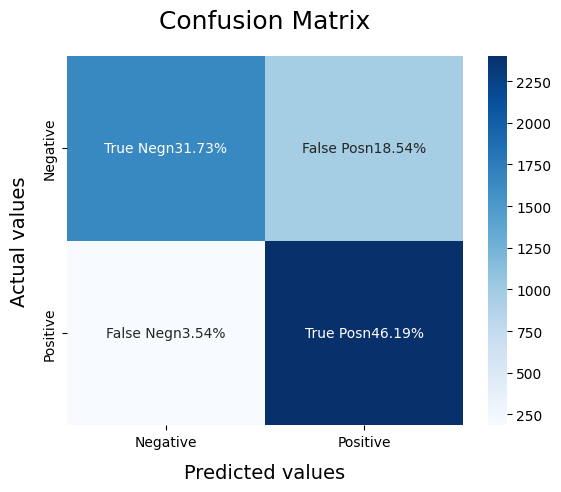

In [23]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

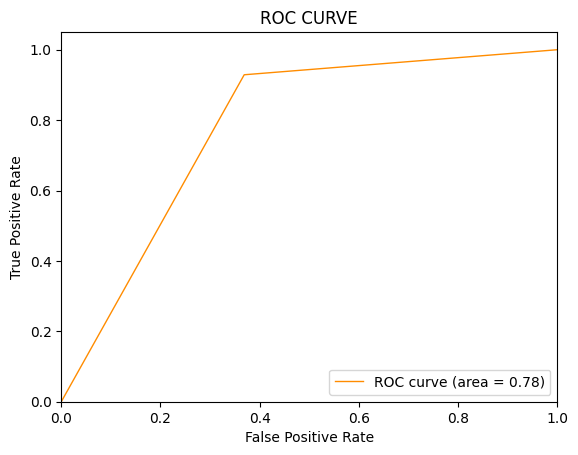

In [24]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2614
           1       0.84      0.85      0.84      2586

    accuracy                           0.85      5200
   macro avg       0.85      0.85      0.85      5200
weighted avg       0.85      0.85      0.85      5200



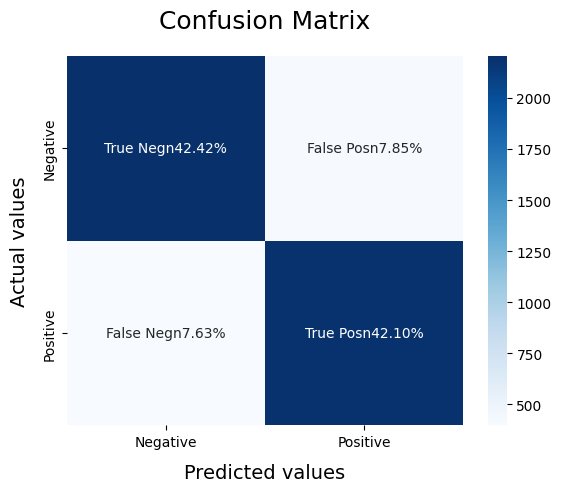

In [25]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

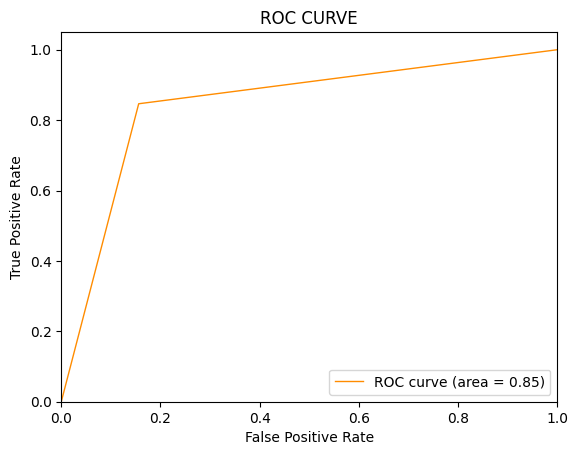

In [26]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()